In [11]:
import numpy as np
from numpy import linalg
from scipy import linalg as splinalg
import matplotlib.pyplot as plt
from scipy import sparse as sp
import scipy.sparse.linalg
from functools import reduce
import itertools
from scipy import linalg
from scipy.linalg import expm
from scipy.special import comb
from itertools import combinations_with_replacement, product
from collections import Counter
import copy
from scipy.linalg import ishermitian

# Bose-Hubbard Model

In [12]:
params = {
    'N': 21, # no. of sites
    't':1.0,
    'localized_site': 10,
    'T': 20,
    'tau': 0.01
}

In [13]:
params['dim'] = 0
params['occupationTuple_lst'] = []
params['Map_ParticleLoc_OccupNo']={}
params['map_occupToD_Dim'] = {}
params['N'], params['k'], params['mu'], params['U'] = 3, 1, 0.4, 1
def dimension(params, **kwargs):
    '''
    For k identical bosonic particles on N lattice site, 
    Changes the dim and initializes the vac state
    based on dim.
    '''
    N, k, dim = params['N'], params['k'], int(params['dim']) # N = number of sites, k = no. of identical bosonic particles
    params['dim'] = int(comb(N+k-1, k)) # This is for k identical bosonic particles
    params['vac'] = np.zeros(N)
    pass

dimension(params)
# print(params)

In [14]:
params['N'], params['k'], params['mu'], params['U'] = 3, 1, 0.3, 1
params['truncationParam_n'] = 2
def creationOpMatrix(params, **kwargs):
    A = sp.diags(np.sqrt(np.arange(1, params['truncationParam_n']+1, 1)), -1)
    return A
# A = creationOpMatrix(params)
# print(A)
def annihilationOpMatrix(params, **kwargs):
    A = sp.diags(np.sqrt(np.arange(1, params['truncationParam_n']+1, 1)), 1)
    return A
# B = annihilationOpMatrix(params)
def numOpMatrix(params, site_no, **kwargs):
    createOp = creationOpMatrix(params)
    nOp = createOp@createOp.transpose()
    I = sp.identity(params['truncationParam_n']+1)
    lst = [I for _ in range(params['N'])]
    if 'tilt' in kwargs:
        lst[site_no] = nOp*site_no
        matrx = sp.csc_matrix(reduce(sp.kron, lst))
        return matrx
    else: 
        lst[site_no] = nOp
        matrix1 = sp.csc_matrix(reduce(sp.kron, lst))
        lst[site_no] = nOp@nOp
        matrix2 = sp.csc_matrix(reduce(sp.kron, lst))
        return matrix1, matrix2
# print(numOpMatrix(params, 1, tilt = True))
def HoppingOpMatrix(params, site_no, **kwargs):
    n, N = params['truncationParam_n'], params['N']
    matrixx = sp.csc_matrix(((n+1)**N, (n+1)**N))
    if site_no != params['N']-1:
        creationOp, annihOp = creationOpMatrix(params), annihilationOpMatrix(params)
        I = sp.identity(params['truncationParam_n']+1)
        lst = [I for _ in range(params['N'])]
        lst[site_no], lst[site_no+1] = creationOp, annihOp
        matrixx = sp.csc_matrix(reduce(sp.kron, lst))
    return matrixx
# HoppingOpMatrix(params, 0) 

In [16]:
def Prod_OccupBasis(params, **kwargs):
    '''
    Generates all combinations using product from itertools.
    Returns: valid_combinations under the k-constraint (particle
    number conservation) and all combinations.
    '''
    n, N, k = params['truncationParam_n']+1, params['N'], params['k']
    all_combinations = dict(enumerate(product(range(n), repeat=N)))
    valid_combinations = dict(filter(lambda x: sum(x[1]) == k, all_combinations.items()))
    return valid_combinations, all_combinations
params['truncationParam_n'], params['N'], params['k'] = 2, 2, 2
# print(Prod_OccupBasis(params)[1])

def projectionMatrix(params, **kwargs):
    '''
    Creates a projection matrix whose elements are non-zero
    for the indices of the occup_states obeying k-constraint.
    '''
    valid_combinations, all_combinations = Prod_OccupBasis(params)
    rows, cols = len(valid_combinations), len(all_combinations)
    PM = sp.csc_matrix((rows, cols))
    for i, key in enumerate(list(reversed(valid_combinations.keys()))):
        PM[i, key] = 1.0
    return PM
# print(projectionMatrix(params))

In [17]:
def HamiltonianMatrix(params, **kwargs):
    n, N, k = params['truncationParam_n'], params['N'], params['k']
    H = sp.csc_matrix(((n+1)**N, (n+1)**N))
    PM = projectionMatrix(params)
    for i in range(N):
        HopOp, nOp_mu = HoppingOpMatrix(params, i), numOpMatrix(params, i, tilt = True)
        NumOp, NumOp_2 = numOpMatrix(params, i)
        H += -params['t']*(HopOp+HopOp.transpose()) + 0.5*params['U']*(NumOp_2 - NumOp) - params['mu']*nOp_mu
    H = PM@H@PM.transpose()
    eigenval, eigenvec = sp.linalg.eigsh(H, k=1, which='SA')
    diag_H = sp.diags(eigenval, format='csc')
    H_reconstructed = eigenvec @ diag_H @ eigenvec.T
    return H, eigenvec
# H, eigenvec = HamiltonianMatrix(params)
# print(repr(H.toarray()))
# print(repr(eigenvec))

In [18]:
def sparse_plotwithColorBar(params, mat, **kwargs):
    '''
    Params: mat - is the sparse matrix.
    Returns scatter plot with a colorbar for visualizing
    sparse matrices. 
    '''
    fig,ax = plt.subplots(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
    plot_list = []
    nonzero_indices = mat.nonzero()
    plot_list = np.array([[col, row, mat[row, col]] for row, col in zip(*nonzero_indices)])
    plot_list = np.array(plot_list)
    plt.scatter(plot_list[:,0],plot_list[:,1],c=plot_list[:,2], s=50)
    cb = plt.colorbar()
    plt.xlim(-1,mat.shape[1])
    plt.ylim(-1,mat.shape[0])
    plt.gca().invert_yaxis()


D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


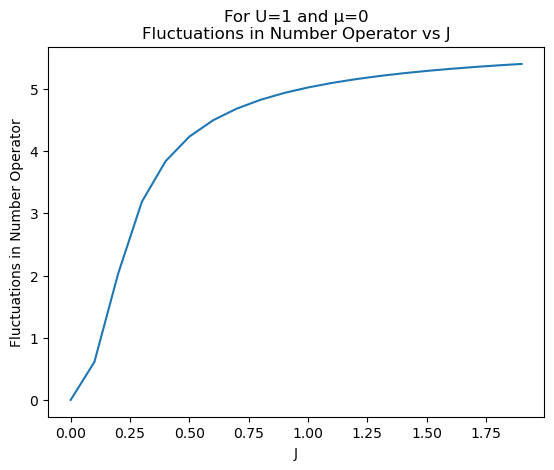

In [42]:
params['hop_list'] = np.arange(0, 2, 0.1)
params['U'], params['mu'] = 1, 0
params['truncationParam_n'], params['N'], params['k'] = 3, 9, 9
def plot_std_numOpVSJ_overU(params, **kwargs):
    '''
    Returns plot of standard deviation of numberOp vs J/U
    '''
    PM, std_val, std = projectionMatrix(params), 0, []
    for t in params['hop_list']:
        params['t'] = t
        _, eigenvec = HamiltonianMatrix(params)
        for i in range(params['N']):
            NumOp, NumOp_2 = numOpMatrix(params, i)
            nOp, nOp_2 = PM@NumOp@PM.transpose(), PM@NumOp_2@PM.transpose()
            expval_nOp, expval_nOp_2 = np.vdot(eigenvec, nOp@eigenvec), np.vdot(eigenvec, nOp_2@eigenvec)
            std_val += expval_nOp_2 - expval_nOp*expval_nOp
        std+=[np.mean(std_val)]
        std_val = 0
    plt.plot(params['hop_list'], std)
    plt.ylabel('Fluctuations in Number Operator')
    plt.xlabel('J')
    mu, U = params['mu'], params['U']
    plt.title(f'For U={U} and μ={mu}\nFluctuations in Number Operator vs J')
    plt.show()
            
plot_std_numOpVSJ_overU(params)       

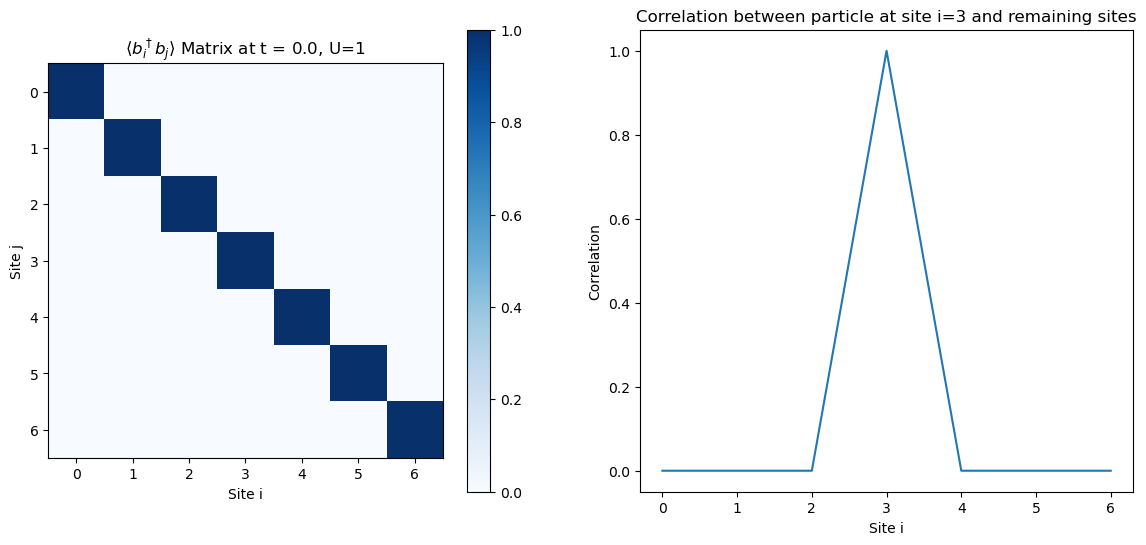

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


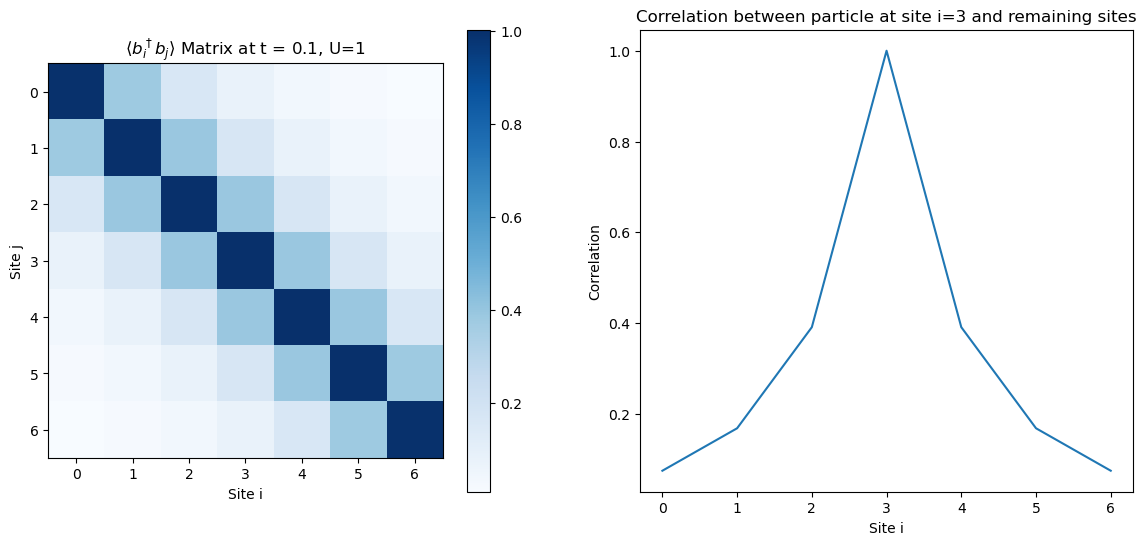

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


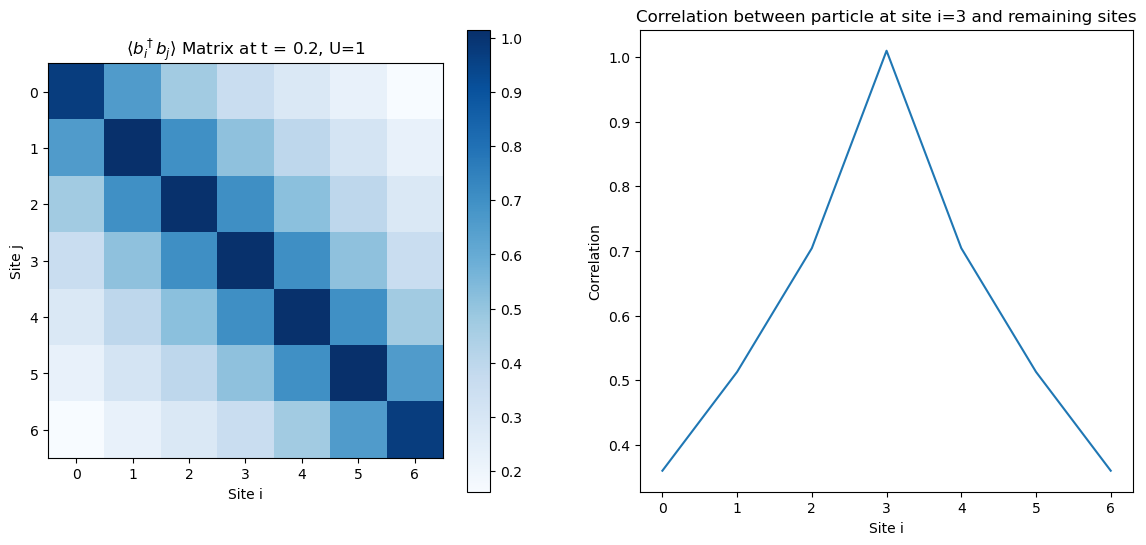

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


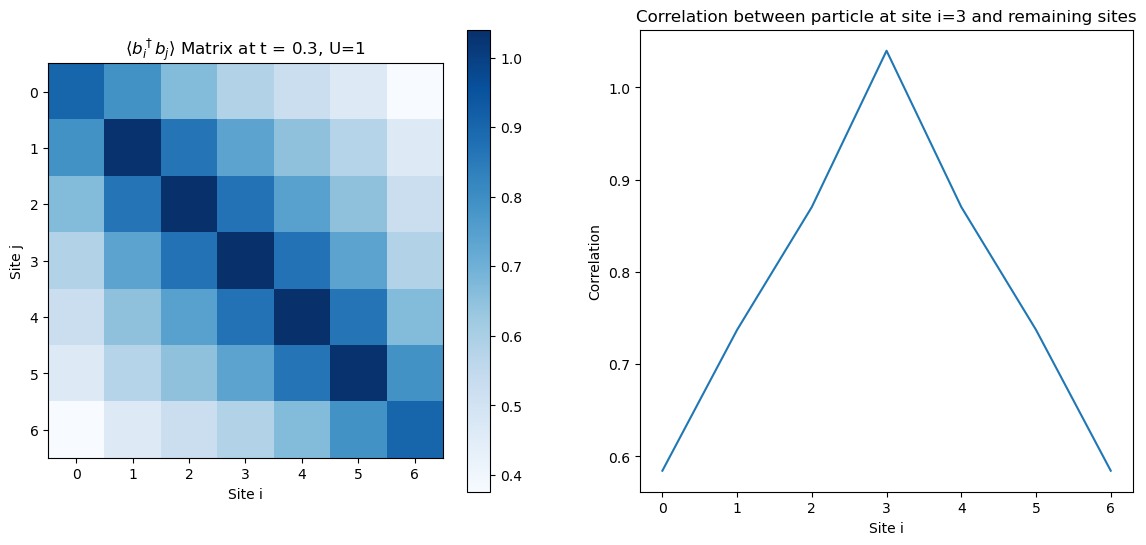

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


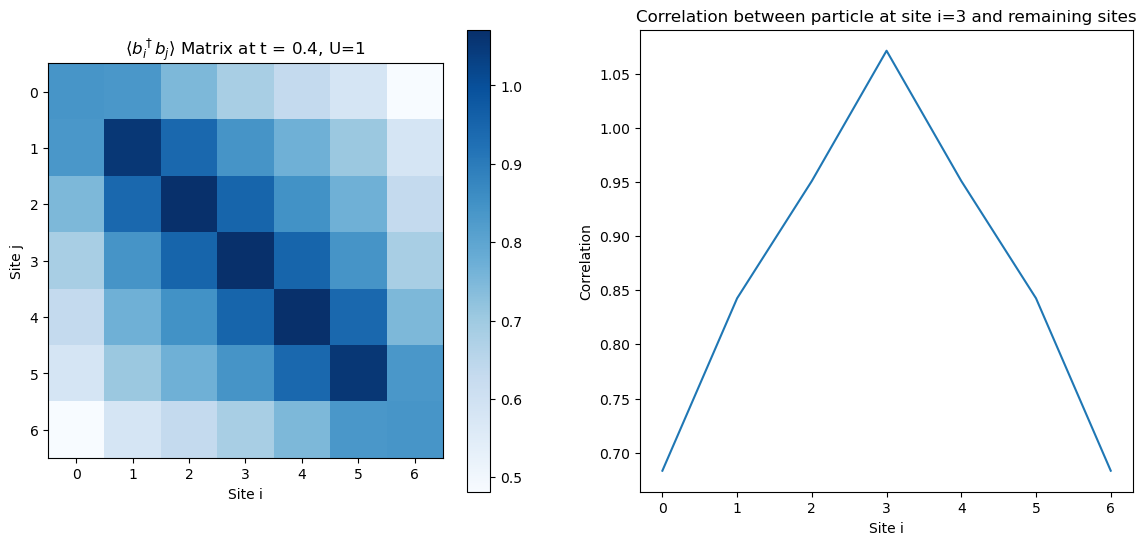

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


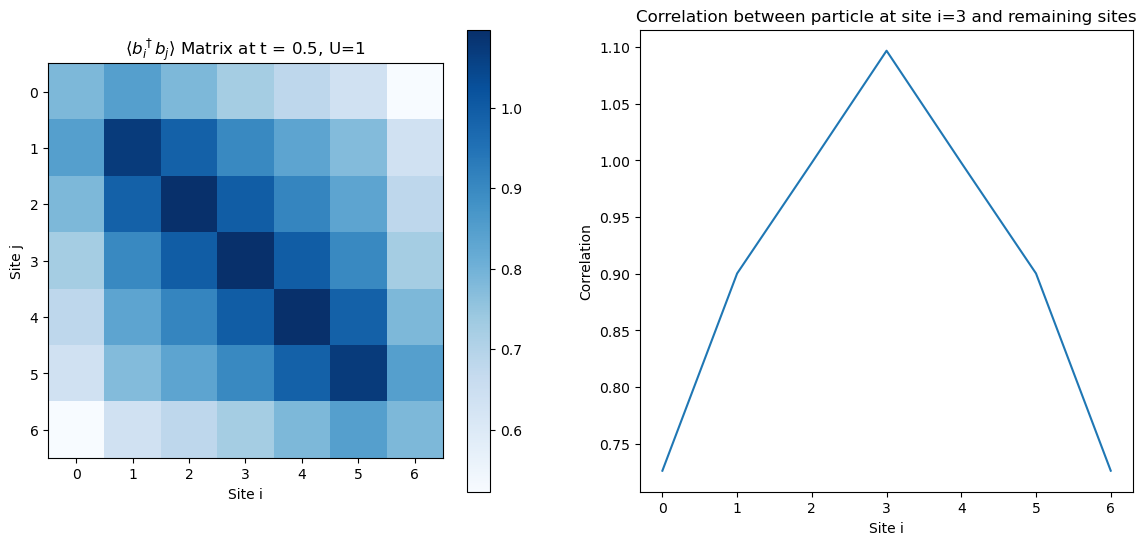

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


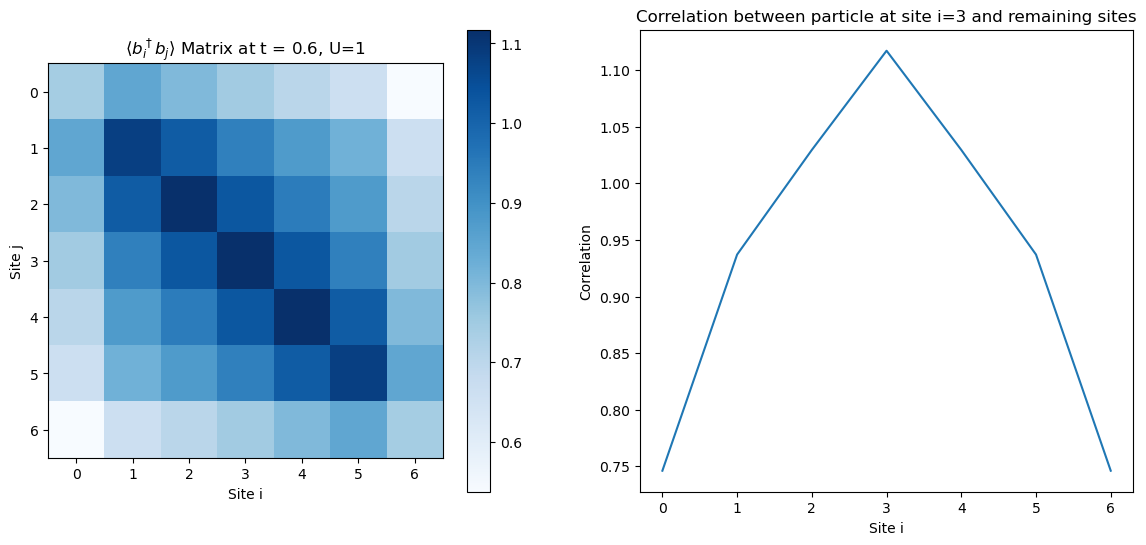

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


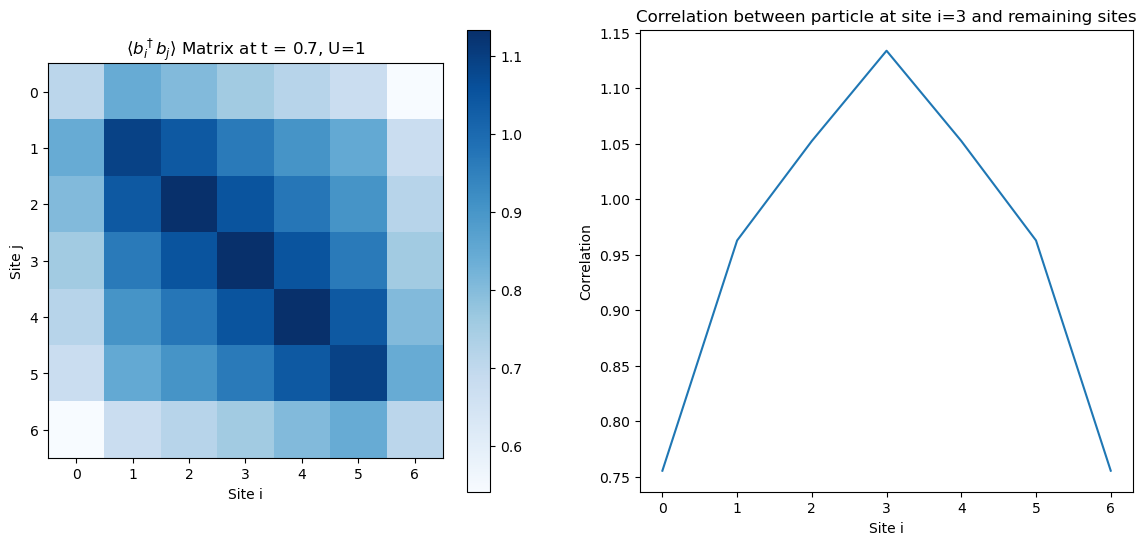

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


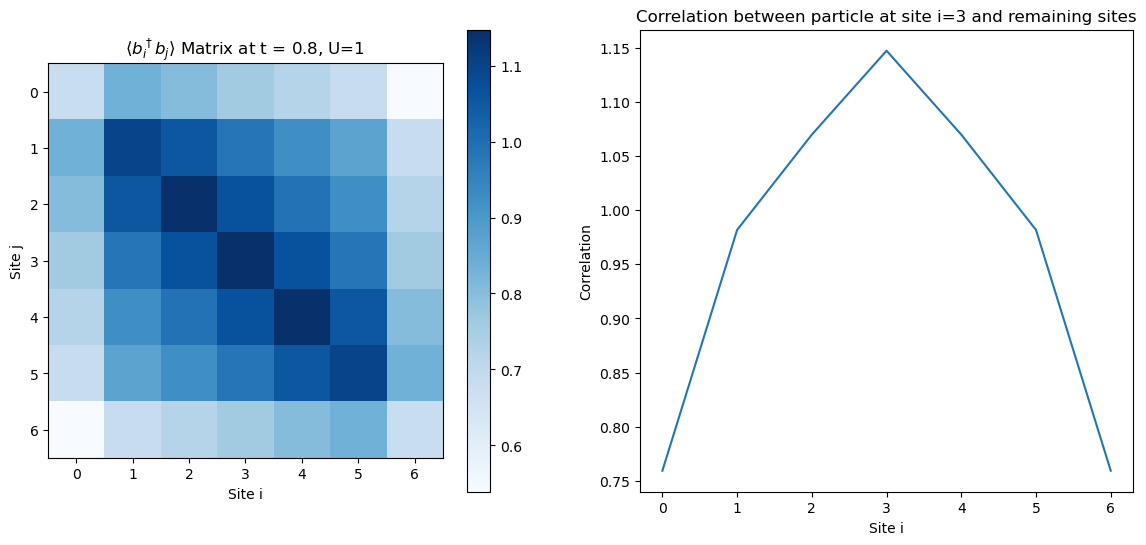

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


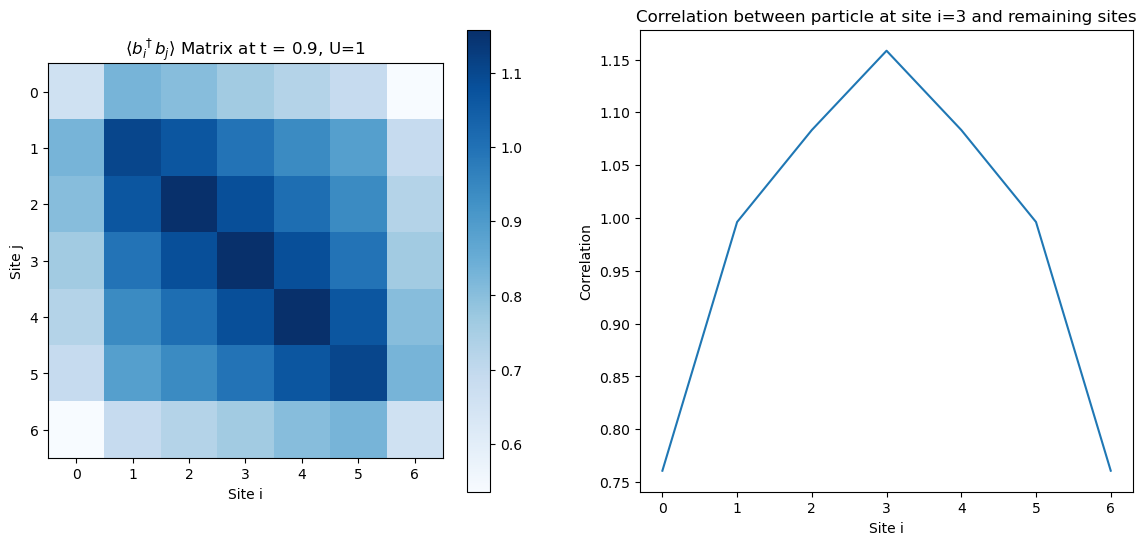

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


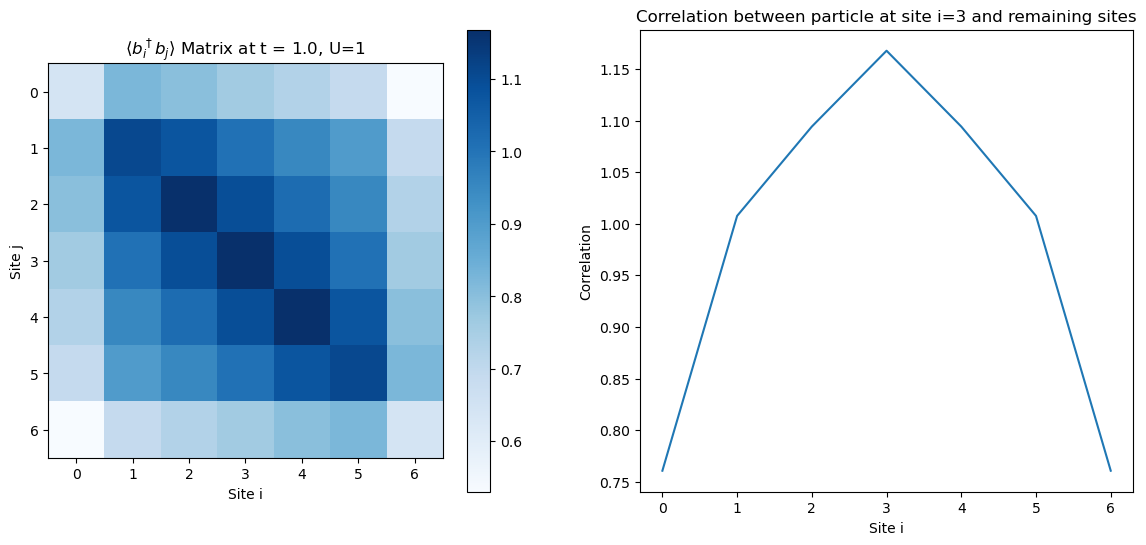

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


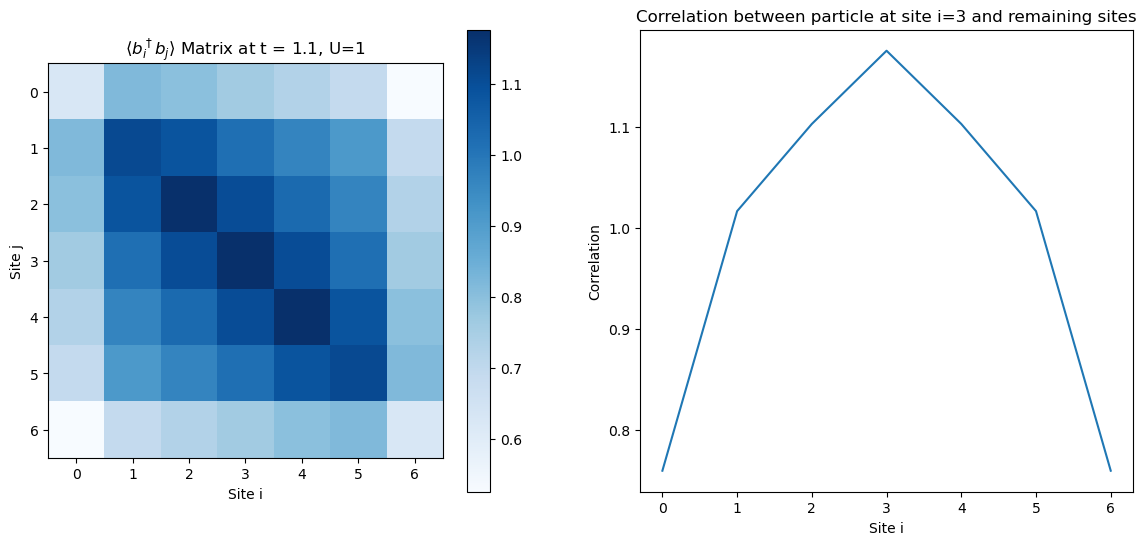

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


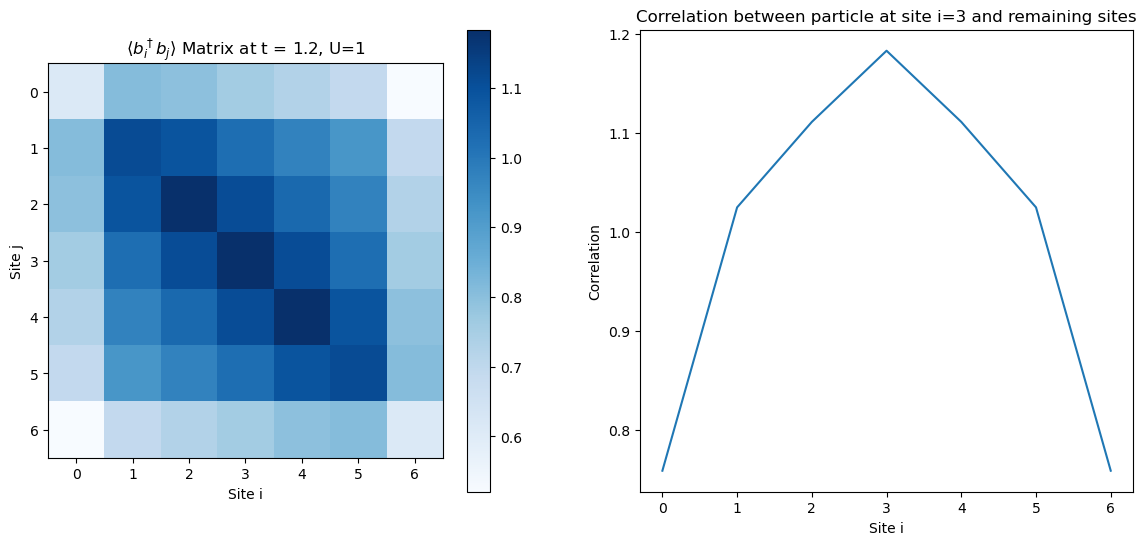

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


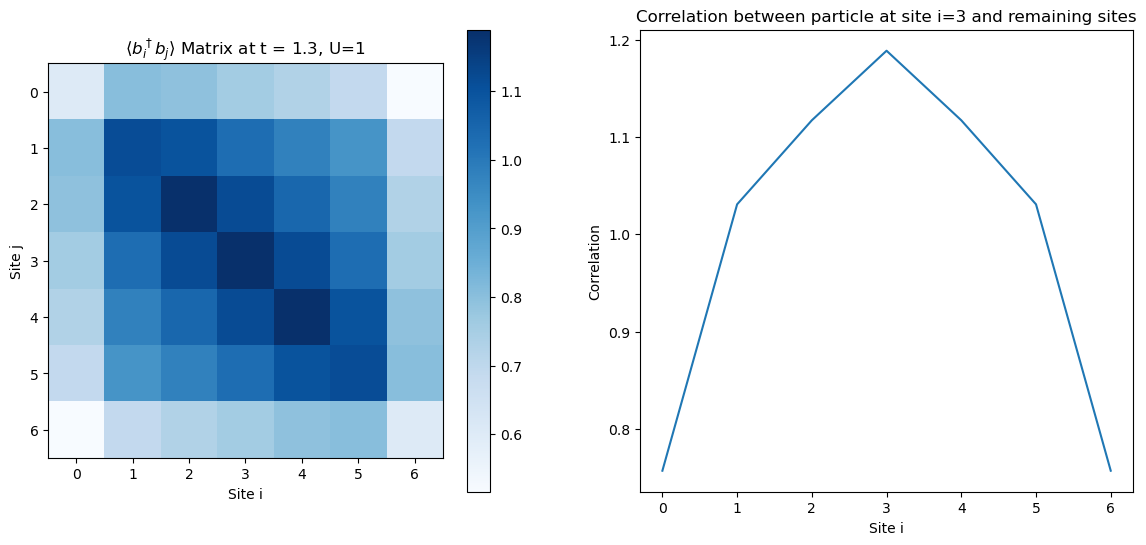

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


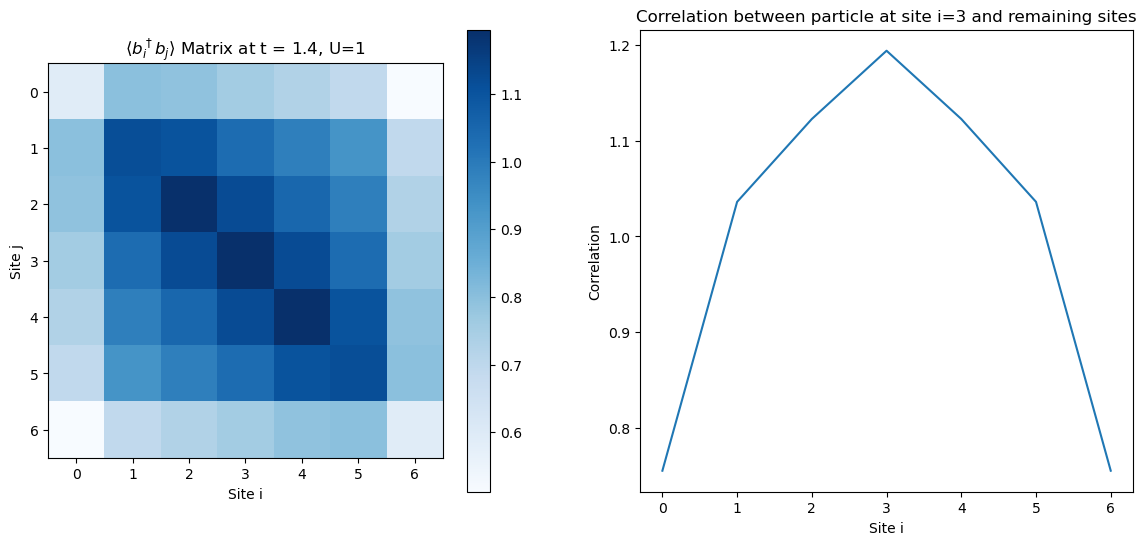

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


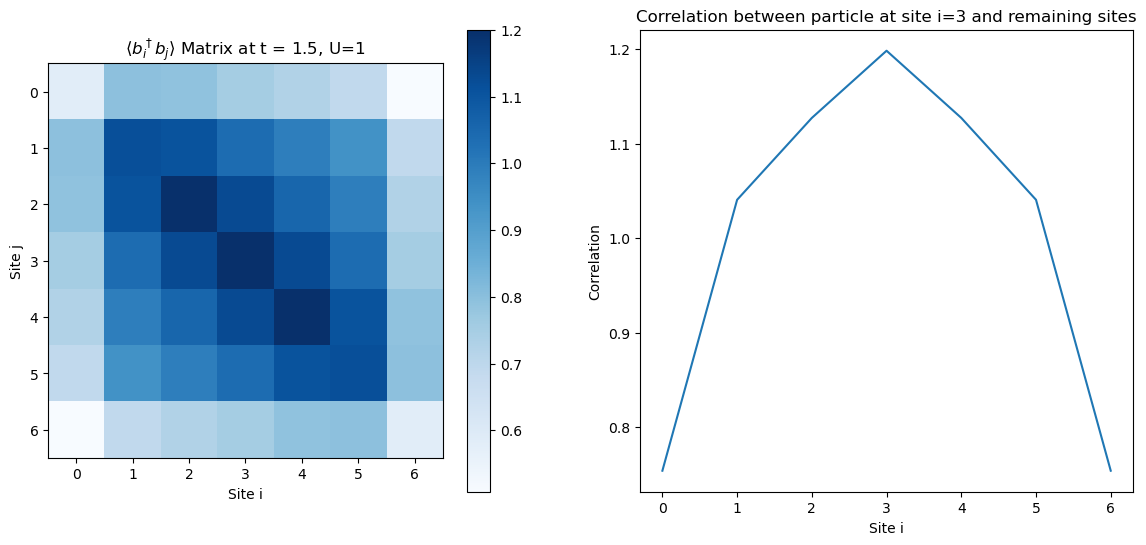

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


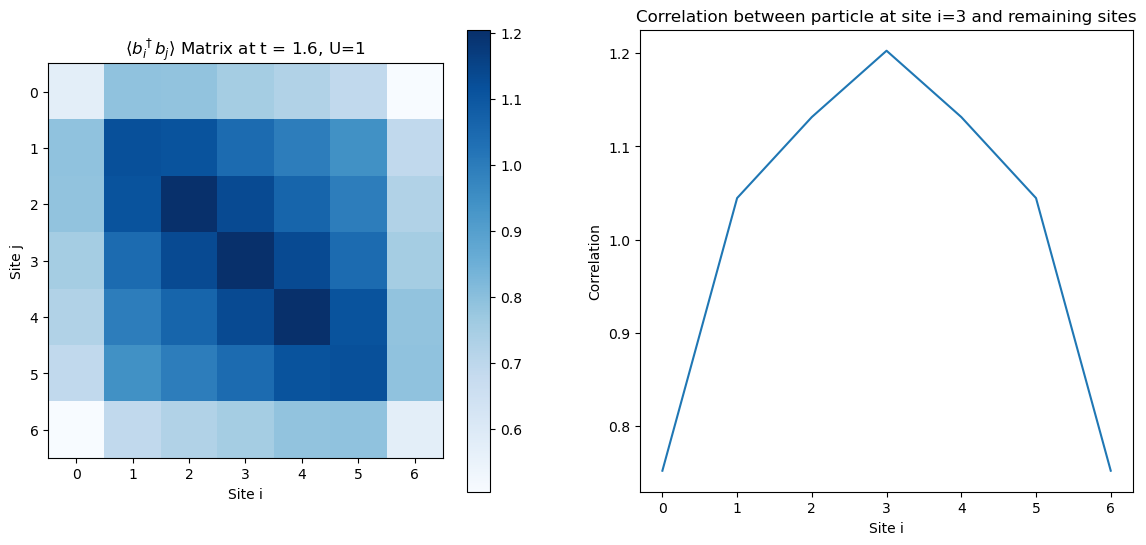

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


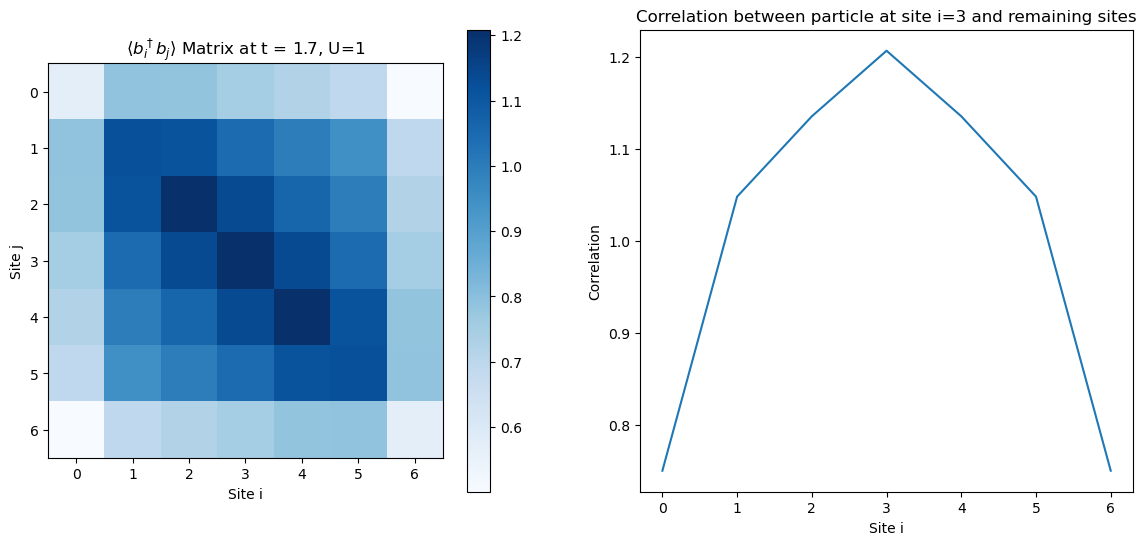

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


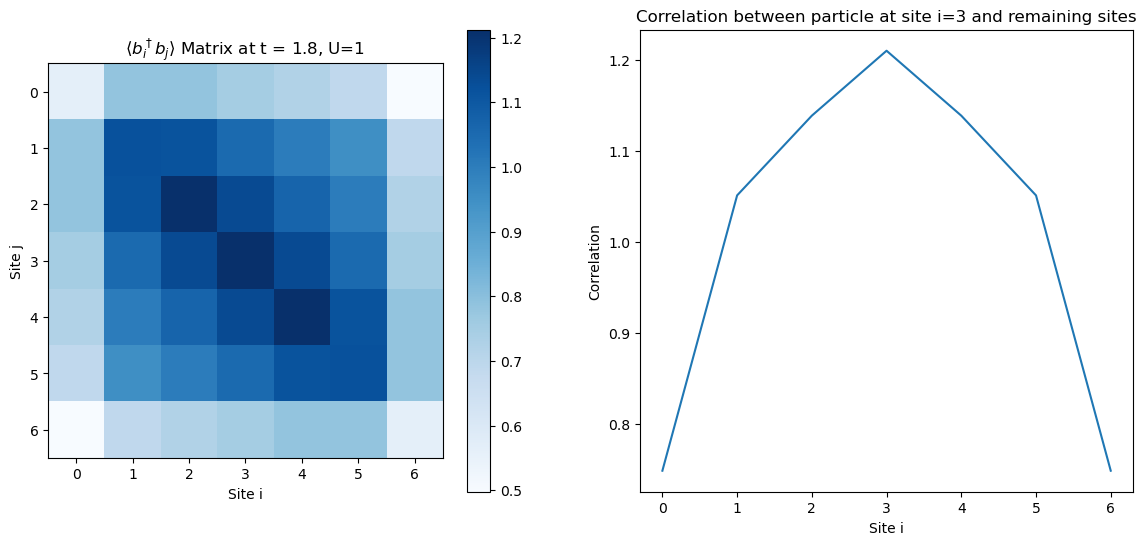

D:\AnacondaFinal\anacondaInstall\envs\WalshPulseSeq\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


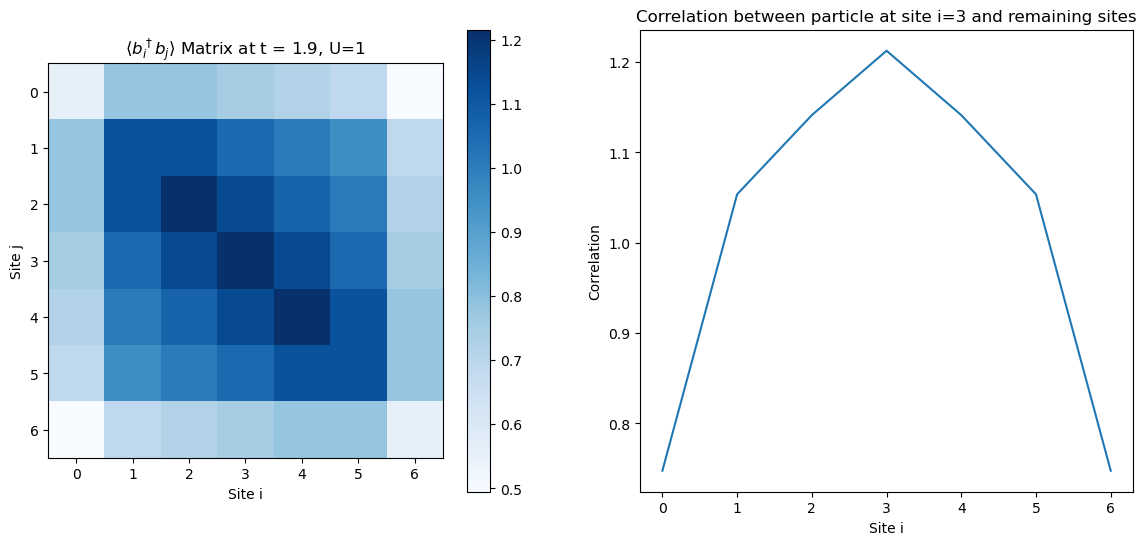

In [30]:
params['U'], params['mu'] = 1, 0
params['truncationParam_n'], params['N'], params['k'] = 3, 7, 7
params['hop_list'] = np.arange(0, 2, 0.1)
def plot_ExpValHoppVsJ_overU(params, **kwargs):
    '''
    Returns plots of Expectation Value of Hopping Ops vs J/U,
    Correlation between particle at the center of lattice and
    the remaining sites.
    '''
    I, annihOp = sp.identity(params['truncationParam_n']+1), annihilationOpMatrix(params)
    PM, createOp, lst = projectionMatrix(params), creationOpMatrix(params), [I for _ in range(params['N'])]
    for t in params['hop_list']:
        params['t'] = t
        H = np.zeros((params['N'], params['N']))
        _, eigenvec = HamiltonianMatrix(params)
        for i in range(params['N']):
            for j in range(params['N']):
                if i == j:
                    lst[i] = createOp@annihOp
                else:
                    lst[i] = createOp
                    lst[j] = annihOp
                HopOp = PM@reduce(sp.kron, lst)@PM.transpose()
                H[i, j] =  np.vdot(eigenvec, HopOp@eigenvec)
                lst[i], lst[j] = I, I
        ## These are used for large lattice sites for which  
        ## sparse matrices are needed.
        ## Use it to visualize sparse matrix without a colorbar.
        # plt.spy(H)
        ## Use it to visualize sparse matrix using a scatterplot with a colorbar
        # sparse_plotwithColorBar(params, mat = H)
        # plt.imshow(H, cmap = "Blues")
        # plt.colorbar()
        # plt.xlabel('Site i')
        # plt.ylabel('Site j')
        # U = params['U']
        # plt.title(f'$\\langle b_i^\\dagger b_j \\rangle$ Matrix at t = {t:.1f}, U={U}')
        # plt.show()
        # middle_index, correlation_rate = (params['N']-1)//2, []
        # expval = H[middle_index, middle_index]
        # for i in range(params['N']):
        #     correlation_rate+=[H[middle_index, i]]
        # plt.plot(list(range(params['N'])), correlation_rate)
        # plt.xlabel('Site i')
        # plt.ylabel(f'Correlation between two particles')
        # plt.title(f'Correlation between particle at site i={middle_index}\n and particle on remaining sites')
        # plt.show()
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))

        im = axs[0].imshow(H, cmap="Blues")
        axs[0].set_xlabel('Site i')
        axs[0].set_ylabel('Site j')
        axs[0].set_title(f'$\\langle b_i^\\dagger b_j \\rangle$ Matrix at t = {t:.1f}, U={params["U"]}')
        fig.colorbar(im, ax=axs[0])

        # Second subplot for the correlation plot
        middle_index = (params['N'] - 1) // 2
        correlation_rate = H[middle_index, :]
        axs[1].plot(list(range(params['N'])), correlation_rate)
        axs[1].set_xlabel('Site i')
        axs[1].set_ylabel('Correlation')
        axs[1].set_title(f'Correlation between particle at site i={middle_index} and remaining sites')

        plt.show()
    pass
H_expval = plot_ExpValHoppVsJ_overU(params)